In [2]:
%%capture
import sys
!{sys.executable} -m pip install -e C:/Users/dbboltje/git/Mechanical-Analysis
import matplotlib.pyplot as plt
import matplotlib

from manalysis import io, filter, util, plot, vibrations, drift, parallel

from pathlib import Path
import numpy as np
import pandas as pd
import glob
import scipy

plot.register_squarerootscale()

## Generate image with vibrations & extract
To verify the vibration analysis we generate an image with a curved intensity step along it. We generate some vibrations and noise and add this to the step edge. Next we extract the vibrations from this image and compare the extracted frequencies and amplitudes.

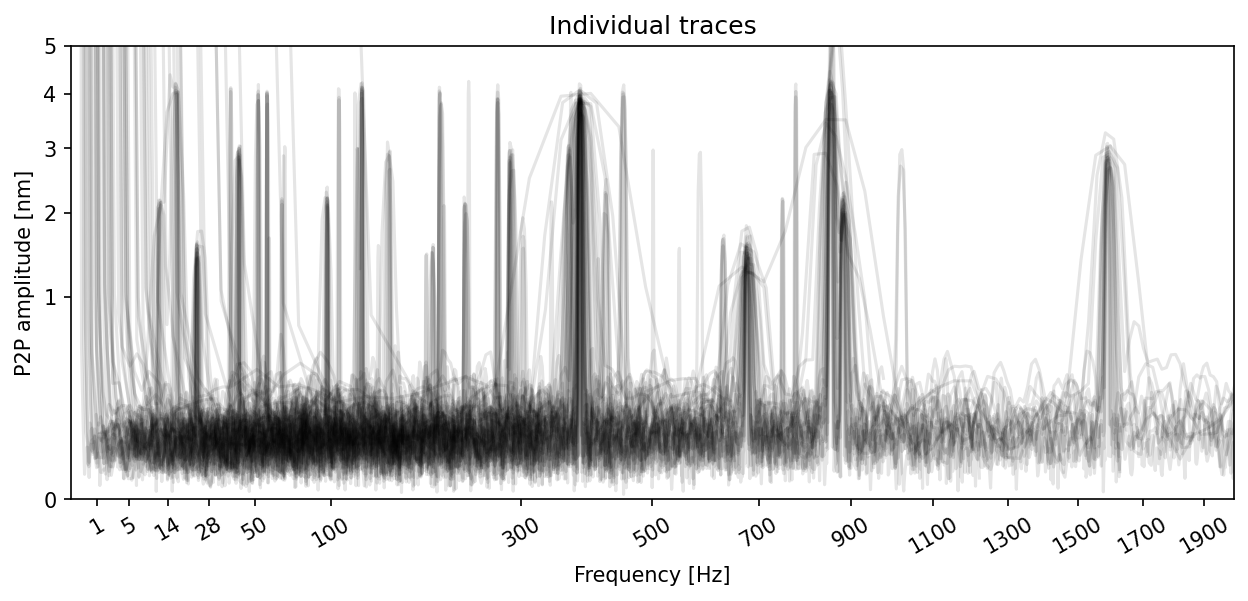

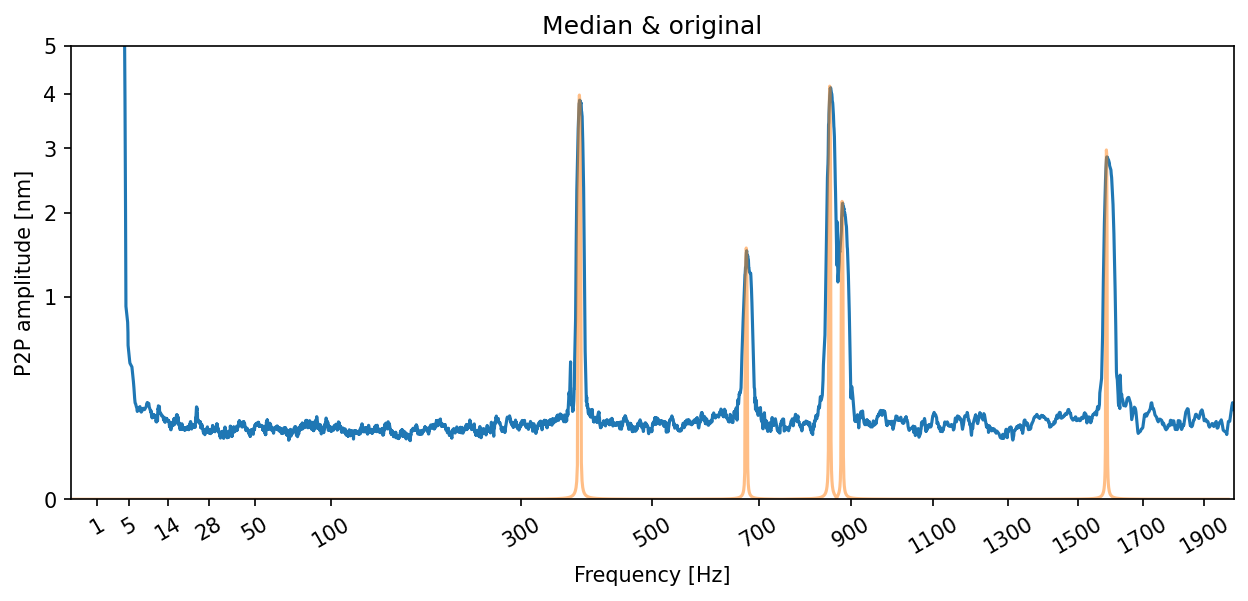

In [333]:
def ball_image(N, M, step_height, offset=0.0):
    N *= 2
    M *= 2
    
    lower = np.zeros((N, M//2))+(1-step_height)-offset
    higher = np.ones((N, M//2))-offset
    im = np.concatenate((lower, higher), axis=1)
    
    shifts = -1.*np.sqrt(M**2 - (np.linspace(0.0, N, N)-N//2)**2)
    im_roll = roll_image(im, shifts)
    
    im_crop = im_roll[N//4:-N//4:,M//4:-M//4]
    return im_crop

def roll_image(im, shifts):
    im_roll = im.copy()
    for i, (r, line) in enumerate(zip(shifts.astype(int), im_roll)):
        im_roll[i] = np.roll(line, r)
    return im_roll

def poisson(im):
    vals = len(np.unique(im))
    vals = 2 ** np.ceil(np.log2(vals))
    poisson = np.random.poisson(im * vals) / float(vals)
    return poisson

def normal(im, mu=0, sigma=0.05):
    normal = np.random.normal(mu, sigma, im.shape)
    return normal

def salt_pepper(im, s_vs_p=0.5, amount=0.05):
    salt_pepper = np.copy(im)
    # Salt mode
    num_salt = np.ceil(amount * im.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in im.shape]
    salt_pepper[tuple(coords)] = 1
    # Pepper mode
    num_pepper = np.ceil(amount* im.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in im.shape]
    salt_pepper[tuple(coords)] = 0
    return salt_pepper

def sampled_vibrations(amplitudes, frequencies, length, sampling_time):
    x = np.linspace(0.0, length*sampling_time, length)
    y = np.zeros_like(x)
    for A, f in zip(amplitudes, frequencies):
        y += A*1.0e-9*0.5*np.sin(f * 2.0*np.pi*x)
    return x, y

def format_sqrtscaled_ax(ax, set_ticks=[], label_rotation=30):
    if set_ticks:
        locs = [float(xt) for xt in set_ticks]
        labels = [matplotlib.text.Text(xt, 0, str(xt)) for xt in set_ticks]
        ax.set_xticks(locs)
        ax.set_xticklabels(labels)
    ax.tick_params(axis='x', which='major', rotation=label_rotation)

pixel_dwells = [100, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000] #
resolutions = [(512, 442), (768, 512), (1024, 884), (1536, 1024), (2048, 1768), (3072, 2048)]
HFW = 100.0e-9 # m
edge_resolution = 2.0e-9 # m
num_vibrations = np.random.randint(2, 6, size=1)
amplitudes = np.random.random(size=num_vibrations) * 4.8 + 0.2
frequencies = np.random.randint(10, 2000, size=num_vibrations)

traces = []
for M, N in resolutions:
        im = ball_image(N, M, 0.2, 0.5)
        pixel_size = HFW / M # m per pixel
        edge_width = edge_resolution / pixel_size
        im_g = scipy.ndimage.gaussian_filter(im, int(edge_width))
        for dwell in pixel_dwells:
                T = dwell*M*1e-9
                x, y = sampled_vibrations(amplitudes, frequencies, N, T)
                xf, yf = filter.scalloping_loss_corrected_fft(y, T)
                # add noise to generated vibrations
                y += 0.5e-9*np.random.normal(0, 1, len(y))
                im_vib = roll_image(im_g, y / pixel_size)
                edge_width = np.max(y / pixel_size) - np.min(y / pixel_size)
                im_crop = im_vib[:,int(edge_width):int(-1*edge_width)]
                noisy_im = im_crop + \
                           normal(im_crop) + \
                           poisson(im_crop) + \
                           salt_pepper(im_crop)
                noisy_im = (255 * ((noisy_im-noisy_im.min()) / (noisy_im.max() - noisy_im.min()))).astype(np.ubyte)
                _, xx, yy = vibrations.extract_vibrations(noisy_im, pixel_width=pixel_size, line_time=T)
                xxf, yyf = filter.scalloping_loss_corrected_fft(yy, T)
                traces.append(pd.Series(yyf, index=xxf))

plt.figure(dpi=150, figsize=(10,4))
for trace in traces:
    plt.plot(trace, c='k', alpha=0.1)
plt.xlim(0, 2000)
plt.ylim(0, 5)
plt.xscale('squareroot')
plt.yscale('squareroot')
plt.xlabel("Frequency [Hz]")
plt.ylabel("P2P amplitude [nm]")
plt.title("Individual traces")
ticks = [1, 5, 14, 28, 50, 100, 300, 500, 700, 
         900, 1100, 1300, 1500, 1700, 1900]
format_sqrtscaled_ax(plt.gca(), set_ticks=ticks)

plt.figure(dpi=150, figsize=(10,4))  
df = pd.concat(traces, axis=1).interpolate('index', limit_area='inside')
median = df.median(axis=1)
plt.plot(median)

T = 1/np.max(frequencies)/2.5
N = int(1/T)
x, y = sampled_vibrations(amplitudes, frequencies, N, T)
xf, yf = filter.scalloping_loss_corrected_fft(y, T)
plt.plot(xf, yf*1e9, alpha=0.5)
plt.xlim(0, 2000)
plt.ylim(0, 5)
plt.xscale('squareroot')
plt.yscale('squareroot')
plt.xlabel("Frequency [Hz]")
plt.ylabel("P2P amplitude [nm]")
plt.title("Median & original")
ticks = [1, 5, 14, 28, 50, 100, 300, 500, 700, 
         900, 1100, 1300, 1500, 1700, 1900]
format_sqrtscaled_ax(plt.gca(), set_ticks=ticks)